# Transfer Learning with TensorFlow Part-3: Scaling up (Food Vision mini) 

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Sun May 28 16:10:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different  tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/UdityaRaj11/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-28 16:10:28--  https://raw.githubusercontent.com/UdityaRaj11/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-28 16:10:28 (102 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook 

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-05-28 16:10:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  23.0MB/s    in 69s     

2023-05-28 16:11:49 (22.5 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [4]:
# How many images classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/crab_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/miso_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10

In [5]:
# Setup data input
!pip install tensorflow-gpu==2.9.1
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
tf.__version__

'2.9.1'

## Train a big dog model with transfer learning on 10% of 101 food classes

Here are steps we're goin to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time). 

In [6]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) #rescale inputs of images to between 0 & 1, required for models like ResNet50 
], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference ode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Get a summary of model we've created
model.summary();

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 99s 376ms/step - loss: 3.3741 - accuracy: 0.2697 - val_loss: 2.4768 - val_accuracy: 0.4733
Epoch 2/5
237/237 [==============================] - 72s 302ms/step - loss: 2.1996 - accuracy: 0.4993 - val_loss: 2.0051 - val_accuracy: 0.5310
Epoch 3/5
237/237 [==============================] - 64s 266ms/step - loss: 1.8230 - accuracy: 0.5695 - val_loss: 1.8581 - val_accuracy: 0.5437
Epoch 4/5
237/237 [==============================] - 61s 253ms/step - loss: 1.5992 - accuracy: 0.6120 - val_loss: 1.7653 - val_accuracy: 0.5556
Epoch 5/5
237/237 [==============================] - 60s 247ms/step - loss: 1.4555 - accuracy: 0.6466 - val_loss: 1.7208 - val_accuracy: 0.5567


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 69s 87ms/step - loss: 1.5784 - accuracy: 0.5860


[1.5784260034561157, 0.5860198140144348]

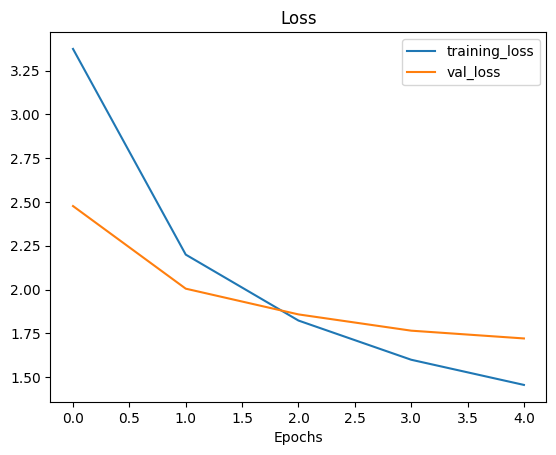

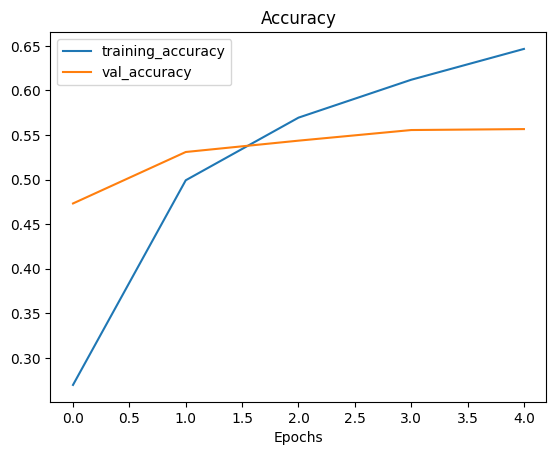

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

Can see our model is overfitting, performing too well on training data but not on testing data.

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [ ]:
# what layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has alreay done 5 epochs (feature extraction), this is the total epochs we are after.

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 [==============================] - 67s 246ms/step - loss: 1.2030 - accuracy: 0.6895 - val_loss: 1.6440 - val_accuracy: 0.5633
Epoch 6/10
237/237 [==============================] - 51s 214ms/step - loss: 1.0859 - accuracy: 0.7164 - val_loss: 1.6699 - val_accuracy: 0.5620
Epoch 7/10
237/237 [==============================] - 55s 229ms/step - loss: 1.0177 - accuracy: 0.7273 - val_loss: 1.6555 - val_accuracy: 0.5689
Epoch 8/10
237/237 [==============================] - 50s 208ms/step - loss: 0.9382 - accuracy: 0.7493 - val_loss: 1.6801 - val_accuracy: 0.5630
Epoch 9/10
237/237 [==============================] - 50s 211ms/step - loss: 0.8752 - accuracy: 0.7654 - val_loss: 1.6649 - val_accuracy: 0.5683
Epoch 10/10
237/237 [==============================] - 50s 211ms/step - loss: 0.8202 - accuracy: 0.7791 - val_loss: 1.6752 - val_accuracy: 0.5665


In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 71s 89ms/step - loss: 1.4666 - accuracy: 0.6115


[1.4666047096252441, 0.6114851236343384]

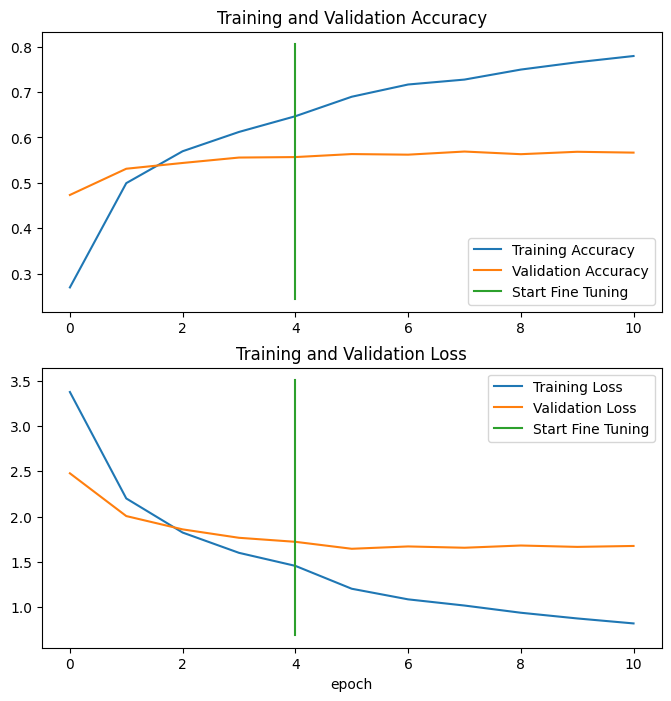

In [ ]:
# Compare the histories of feature extraction model with fine-tuned model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model
To use our model in externaml application, we'll need to save it and export it somewhere.


In [10]:
# Save model using the SavedModel format
model.save("drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model")

NameError: ignored

In [2]:
import tensorflow as tf

In [7]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model")

In [8]:
#Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 81s 91ms/step - loss: 1.4666 - accuracy: 0.6115


[1.4666050672531128, 0.6114851236343384]

In [14]:
# The results from our loaded_model should be very similar to the results below
all_classes_10_percent_fine_tune_results

NameError: ignored

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.


In [9]:
#Download pretrained model on that was prepared earlier.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-05-28 16:14:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  14.3MB/s    in 3.1s    

2023-05-28 16:14:35 (14.3 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [10]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [11]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [12]:
# Evaluate loaded model (the one we just load)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 74s 91ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [13]:
loaded_model_results

[1.4666050672531128, 0.6114851236343384]

## Making predictions wuth our trained model

In [15]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 74s 92ms/step


In [16]:
len(test_data)

790

In [17]:
# How many predictions are there?
len(preds_probs)

25250

In [19]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [20]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.95419593e-02, 3.57420868e-06, 4.13769372e-02, ...,
        1.41386813e-09, 8.35309183e-05, 3.08975438e-03],
       [9.64016795e-01, 1.37531941e-09, 8.47800926e-04, ...,
        5.42870985e-05, 7.83620651e-12, 9.84658355e-10],
       [9.59258795e-01, 3.25336805e-05, 1.48669782e-03, ...,
        7.18914862e-07, 5.43973215e-07, 4.02759688e-05],
       ...,
       [4.73133087e-01, 1.29311971e-07, 1.48055784e-03, ...,
        5.97499893e-04, 6.69690344e-05, 2.34693653e-05],
       [4.45719399e-02, 4.72655216e-07, 1.22585125e-01, ...,
        6.34988646e-06, 7.53187896e-06, 3.67790065e-03],
       [7.24389851e-01, 1.92497041e-09, 5.23109557e-05, ...,
        1.22913881e-03, 1.57927493e-09, 9.63954080e-05]], dtype=float32)

In [23]:
# What does the first prediction probability look like?
preds_probs[:1], len(preds_probs[0])

(array([[5.9541959e-02, 3.5742087e-06, 4.1376937e-02, 1.0660597e-09,
         8.1614289e-09, 8.6639336e-09, 8.0927123e-07, 8.5652829e-07,
         1.9859091e-05, 8.0977929e-07, 3.1727747e-09, 9.8673661e-07,
         2.8532220e-04, 7.8049051e-10, 7.4230169e-04, 3.8916383e-05,
         6.4740439e-06, 2.4977232e-06, 3.7891168e-05, 2.0678348e-07,
         1.5538451e-05, 8.1507108e-07, 2.6230543e-06, 2.0010630e-07,
         8.3827774e-07, 5.4215889e-06, 3.7391001e-06, 1.3150533e-08,
         2.7761592e-03, 2.8051838e-05, 6.8562162e-10, 2.5574835e-05,
         1.6688945e-04, 7.6407003e-10, 4.0452956e-04, 1.3150686e-08,
         1.7957415e-06, 1.4448218e-06, 2.3062879e-02, 8.2466948e-07,
         8.5365781e-07, 1.7138647e-06, 7.0525239e-06, 1.8402240e-08,
         2.8553461e-07, 7.9483689e-06, 2.0681514e-06, 1.8525208e-07,
         3.3619774e-08, 3.1522615e-04, 1.0410933e-05, 8.5448698e-07,
         8.4741873e-01, 1.0555435e-05, 4.4094759e-07, 3.7404072e-05,
         3.5306333e-05, 3.2489133e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [26]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest prediction probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9541959e-02 3.5742087e-06 4.1376937e-02 1.0660597e-09 8.1614289e-09
 8.6639336e-09 8.0927123e-07 8.5652829e-07 1.9859091e-05 8.0977929e-07
 3.1727747e-09 9.8673661e-07 2.8532220e-04 7.8049051e-10 7.4230169e-04
 3.8916383e-05 6.4740439e-06 2.4977232e-06 3.7891168e-05 2.0678348e-07
 1.5538451e-05 8.1507108e-07 2.6230543e-06 2.0010630e-07 8.3827774e-07
 5.4215889e-06 3.7391001e-06 1.3150533e-08 2.7761592e-03 2.8051838e-05
 6.8562162e-10 2.5574835e-05 1.6688945e-04 7.6407003e-10 4.0452956e-04
 1.3150686e-08 1.7957415e-06 1.4448218e-06 2.3062879e-02 8.2466948e-07
 8.5365781e-07 1.7138647e-06 7.0525239e-06 1.8402240e-08 2.8553461e-07
 7.9483689e-06 2.0681514e-06 1.8525208e-07 3.3619774e-08 3.1522615e-04
 1.0410933e-05 8.5448698e-07 8.4741873e-01 1.0555435e-05 4.4094759e-07
 3.7404072e-05 3.5306333e-05 3.2489133e-05 6.7314817e-05 1.2852616e-08
 2.6219760e-10 1.0318100e-05 8.5744126e-05 1.

In [28]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [29]:
# how many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the labels.


In [30]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index where 1 occurs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

One way to check that our model's as our predictions array is in same order as our test labels array is to find the accuracy score.

In [32]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [33]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

0.6077623762376237

In [34]:
# Does this metrics come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making confusion matrix

In [35]:
from helper_functions import make_confusion_matrix

In [36]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [42]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

Output hidden; open in https://colab.research.google.com to view.

## let's keep the evaluation train going, time for classification report

Scikit-learn has helpful funcyion for acquiring many different classification metrics per class (e.g. precision recalss and F1) called classification_report.

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.
How about we create a visualization to get a better understanding?

In [44]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all of our classes F1-scores....

In [45]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [47]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

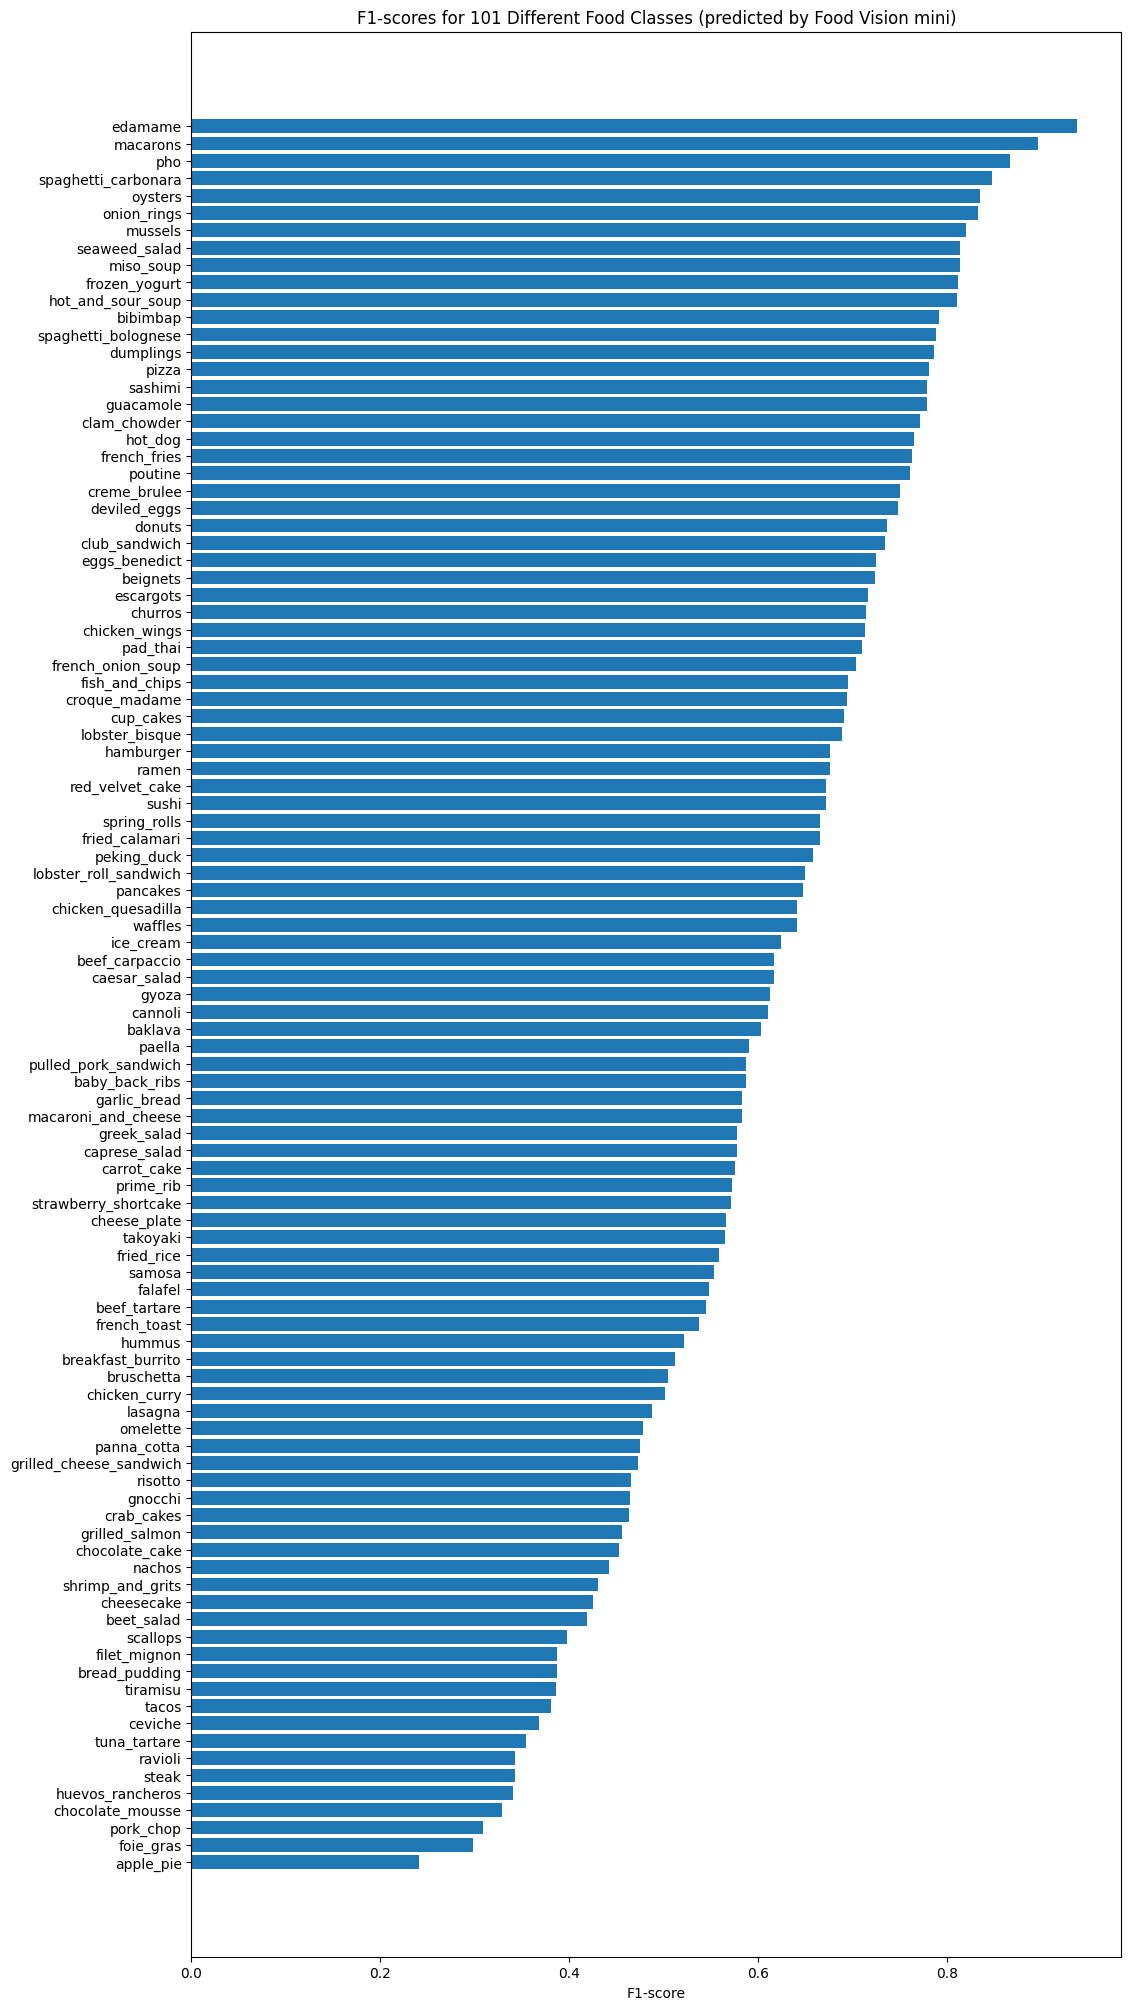

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

# Challenge: add values to the end of each bar of what the actual f1-score is

## Visualizing predictions on custom images
Now, this is the real test, how does our model go on food images not even in our test dataset(images of oue own).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1 (if necessary)

In [53]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image

  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficienNet models in TensorFlow


Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 51ms/step


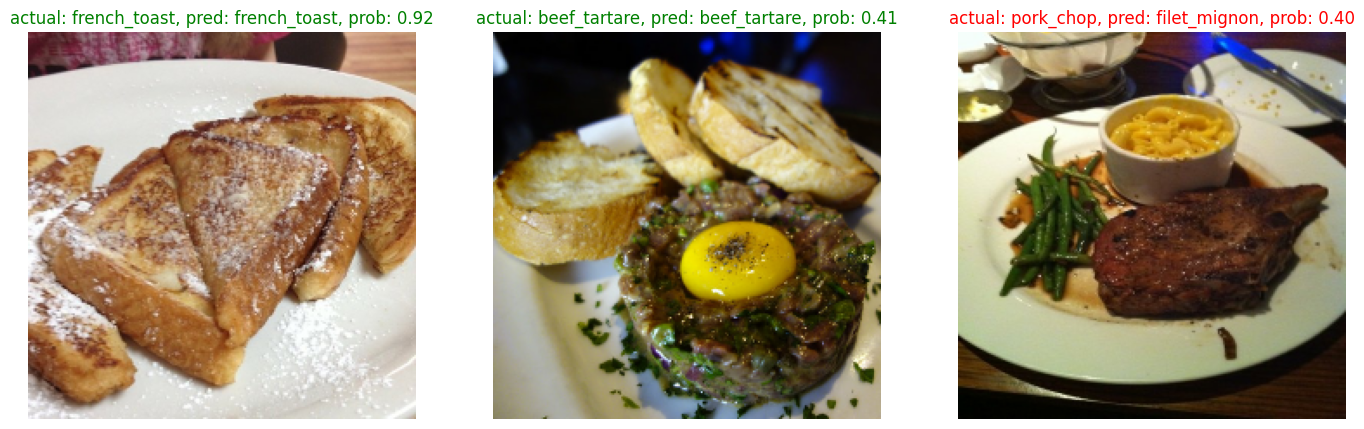

In [85]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = loaded_model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest predictions
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if (class_name == pred_class): # if predicted class match turth class, make it green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}",  color=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities.
3. Use our DataFrame to find all the wrong predictions (where the ground turth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions(have the highest prediction probability prediction at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [86]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]



[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [88]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # Get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658606        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501949          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [89]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658606        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [91]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

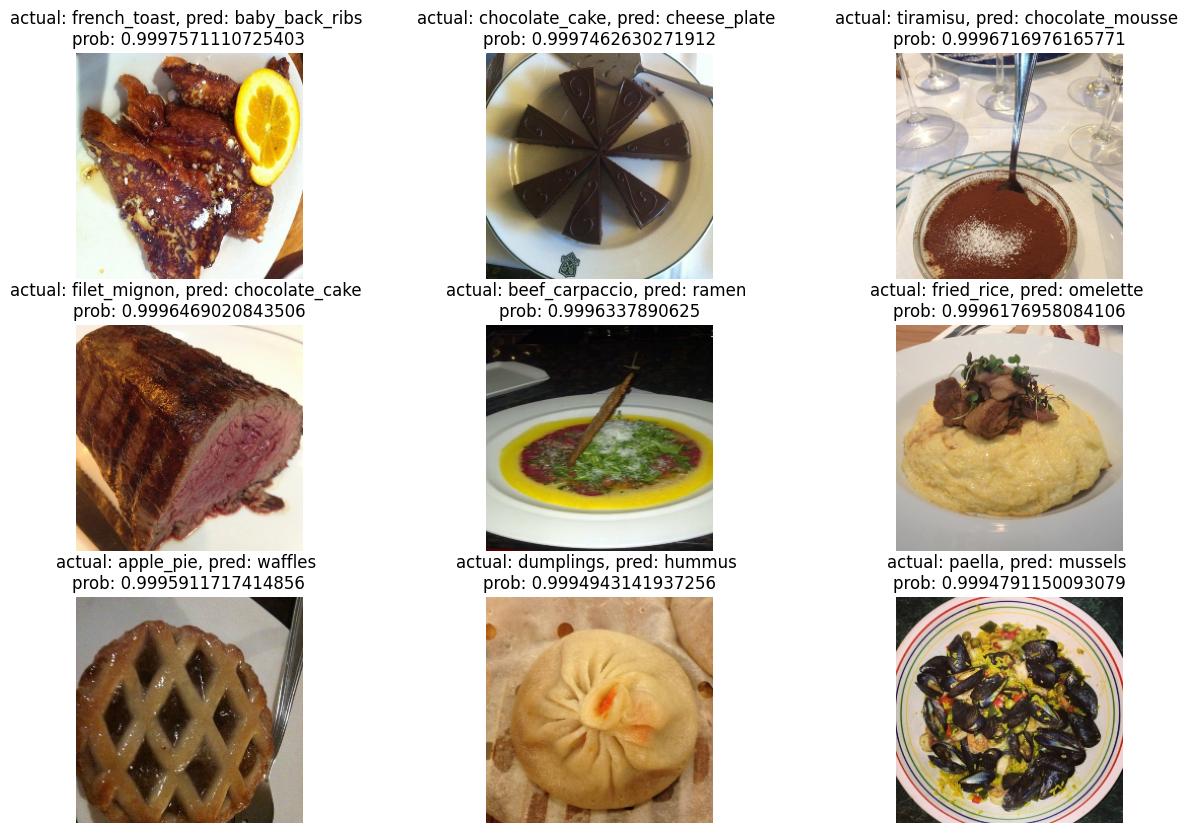

In [97]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [99]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-05-28 19:51:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  6.39MB/s    in 2.0s    

2023-05-28 19:51:25 (6.39 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [100]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 48ms/step


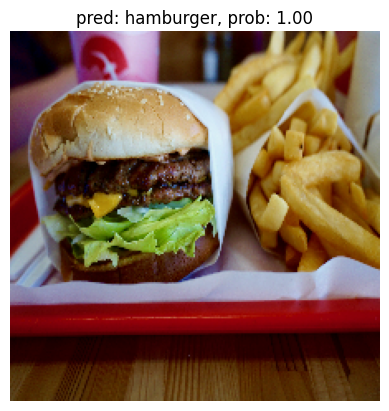

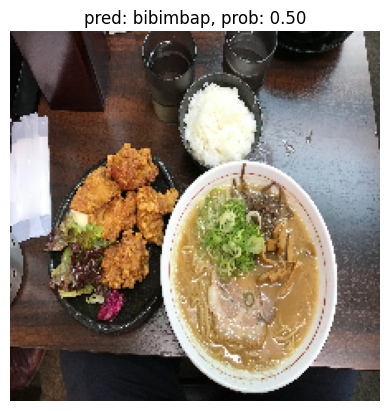

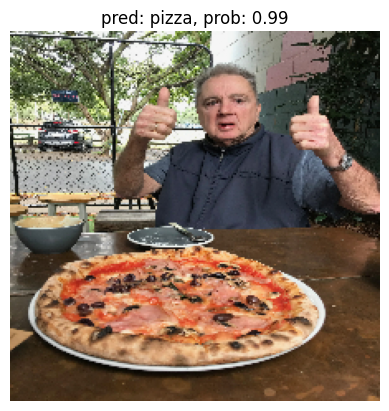

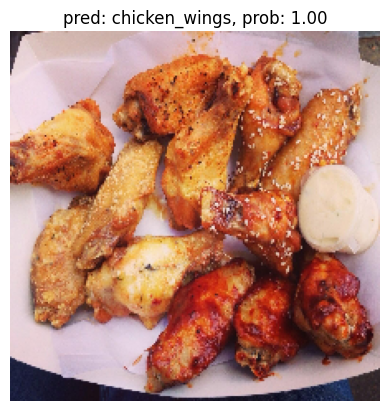

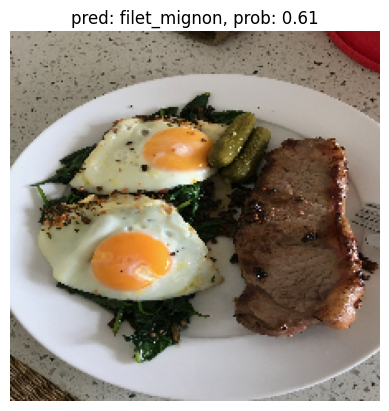

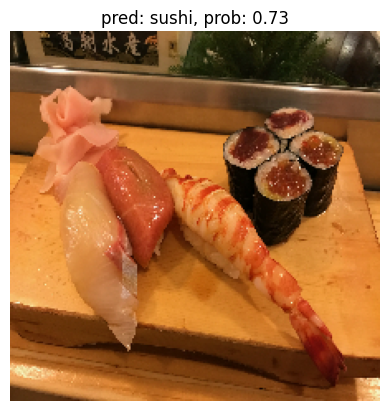

In [101]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # Don't need to scale for our EfficientNetB0 model
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # make predictions on image with shape [1, 224, 224, 3] (same shape model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highest prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)